In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr, spearmanr

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import warnings
import re
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv("genes/combined-gene-on-off.csv")
df["inr_effect"] = df["Sum of initiator effect"]
for motif in ["NRF1", "ZNF143", "NFY", "ETS", "CREB", "SP"]:
    df[motif] = df[f'{motif} +'] + df[f'{motif} -']
df.shape

(83, 53)

In [3]:
df_off = pd.DataFrame(columns=['gene', 'celltype', 'off-period'])
for index, row in df.iterrows():
    gene = row['gene']
    celltype = row['celltype']

    # Extract off-period values from the string
    off_periods = [int(period) for period in re.findall(r'\d+', row['off-period'])]
    
    # Append each off-period to the new DataFrame
    for off_period in off_periods:
        if off_period >= 2:
            df_off = df_off.append({'gene': gene, 'celltype': celltype, 'off-period': off_period}, ignore_index=True)


df_off['off-period'] = df_off['off-period'].astype(int)
df_off = pd.merge(df_off, df.drop('off-period', axis=1), on=["gene", "celltype"])
df_off.shape

(7105, 53)

In [4]:
# df_off[["gene", "celltype", "CREB", "off-mean", "off-period-counts"]].drop_duplicates().sort_values("CREB", ascending=False)

In [5]:
df_on = pd.DataFrame(columns=['gene', 'celltype', 'on-period'])
for index, row in df.iterrows():
    gene = row['gene']
    celltype = row['celltype']

    # Extract on-period values from the string
    on_periods = [int(period) for period in re.findall(r'\d+', row['on-period'])]
    
    # Append each on-period to the new DataFrame
    for on_period in on_periods:
        if on_period >= 2:
            df_on = df_on.append({'gene': gene, 'celltype': celltype, 'on-period': on_period}, ignore_index=True)


df_on['on-period'] = df_on['on-period'].astype(int)
df_on = pd.merge(df_on, df.drop('on-period', axis=1), on=["gene", "celltype"])
df_on.shape

(6227, 53)

In [6]:
df_off.celltype.value_counts()

HBEC    5347
H9D3    1157
H9D0     601
Name: celltype, dtype: int64

In [7]:
# df_off[df_off["off-period"] < 5]["off-period"].hist()

In [8]:
# xcols = [ "gene", "off-period", 'TATA +', 'YY1 +',
#          'NRF1', 'NRF1 +', 'NRF1 -',
#          'ZNF143', 'ZNF143 +', 'ZNF143 -',
#          'NFY', 'NFY +', 'NFY -',
#          'ETS', 'ETS +', 'ETS -',
#          'CREB', 'CREB +', 'CREB -',
#          'SP', 'SP +', 'SP -', 
#          'U1 snRNP +',
#         'inr_effect']
# df_off[xcols].sample(500).to_csv("temp.csv", index=False)

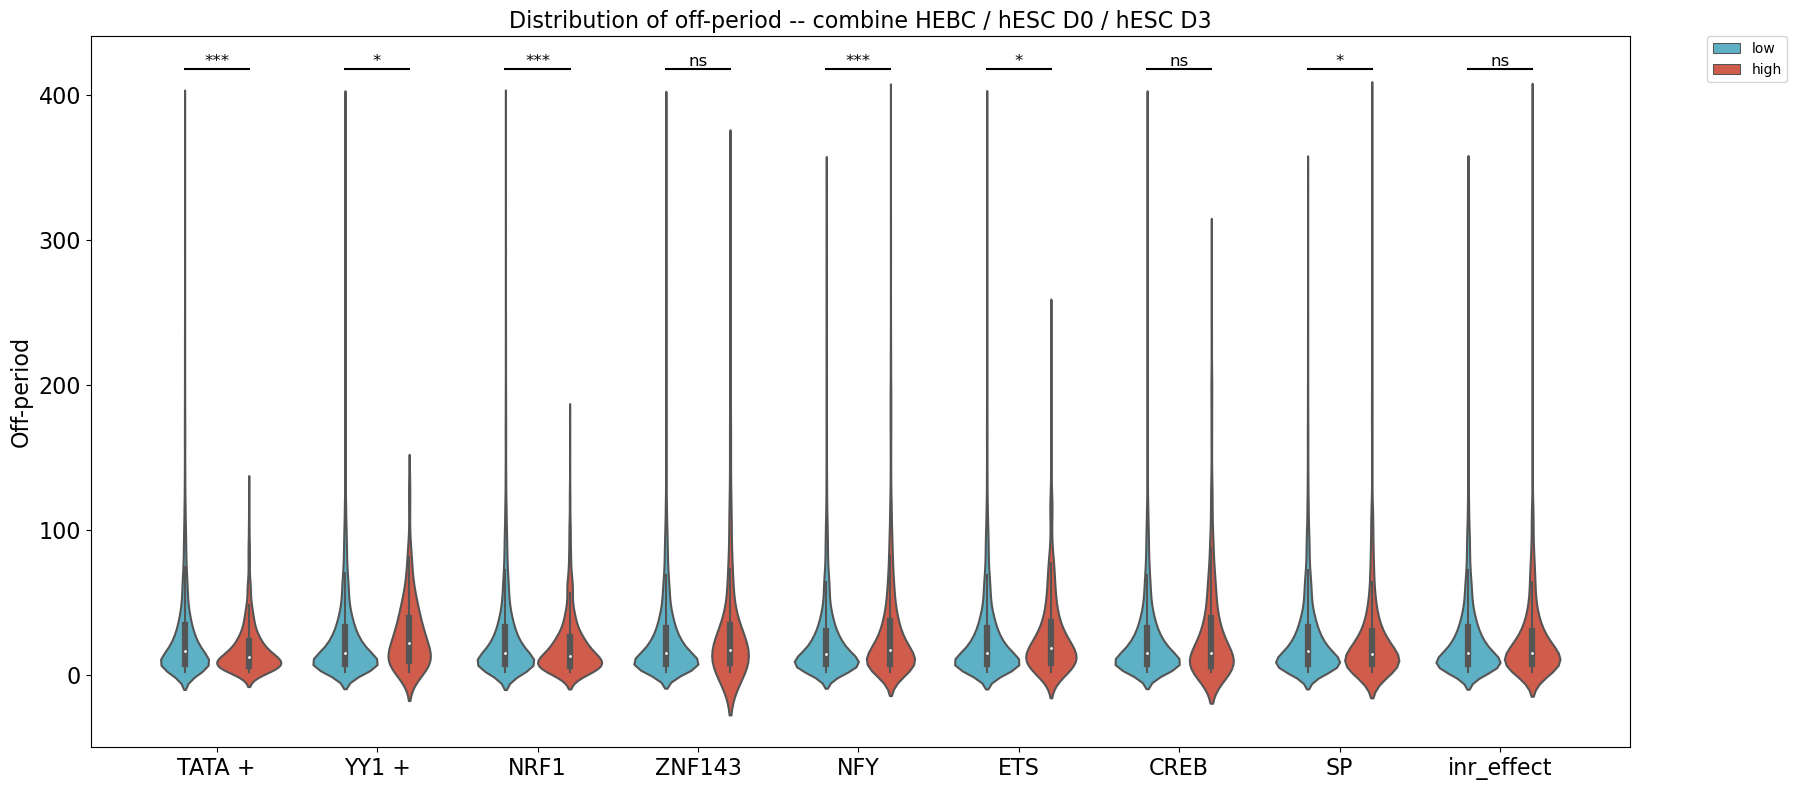

In [12]:
xcols = [ 'TATA +', 'YY1 +',
         'NRF1', 'NRF1 +', 'NRF1 -',
         'ZNF143', 'ZNF143 +', 'ZNF143 -',
         'NFY', 'NFY +', 'NFY -',
         'ETS', 'ETS +', 'ETS -',
         'CREB', 'CREB +', 'CREB -',
         'SP', 'SP +', 'SP -', 
         'U1 snRNP +',
        'inr_effect']

xcols = [ 'TATA +', 'YY1 +',
         'NRF1', 
         'ZNF143', 
         'NFY',
         'ETS',
         'CREB', 
         'SP', 
         'inr_effect']

long_data = []

for xcol in xcols:
    data = df_off[~df_off[xcol].isnull()].copy()
    data['group'] = xcol
    data['group_type'] = data.apply(lambda row: f'high' if row[xcol] > 1 else f'low', axis=1)
    long_data.append(data[['off-period', 'group', 'group_type']])

long_data = pd.concat(long_data)

plt.figure(figsize=(18, 8))
ax = sns.violinplot(x='group', y='off-period', hue='group_type', 
                    data=long_data, palette={"high": "#E64B35", "low": "#4DBBD5"})
plt.title('Distribution of off-period -- combine HEBC / hESC D0 / hESC D3', fontsize=16)
plt.ylabel('Off-period', fontsize=16)
plt.xlabel('')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Annotate p-values
for xcol in xcols:
    data = df_off[~df_off[xcol].isnull()].copy()
    data[f'{xcol}_group'] = data.apply(lambda row: f'high_{xcol}' if row[xcol] > 1 else f'low_{xcol}', axis=1)
    
    d1 = data[data[f'{xcol}_group'] == f'high_{xcol}']['off-period']
    d2 = data[data[f'{xcol}_group'] == f'low_{xcol}']['off-period']
    
    stat, p = mannwhitneyu(d1, d2)
    
    # Determine significance levels
    if p < 0.001:
        p_value_text = '***'
    elif p < 0.01:
        p_value_text = '**'
    elif p < 0.05:
        p_value_text = '*'
    else:
        p_value_text = 'ns'
    
    # Find the position to annotate the p-value
    group_idx = xcols.index(xcol)
    x_position = group_idx
    y_position = 420

    ax.text(x=x_position, y=y_position, s=p_value_text, ha='center', fontsize=12, color='black')
    
    x1 = group_idx - 0.2
    x2 = group_idx + 0.2
    y = 418
    h = 0.05  # Line height
    
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')  # Adjust color and line width as needed


plt.tight_layout()
plt.savefig("figs/Distribution of off-period.tif", format='tiff')
plt.show()

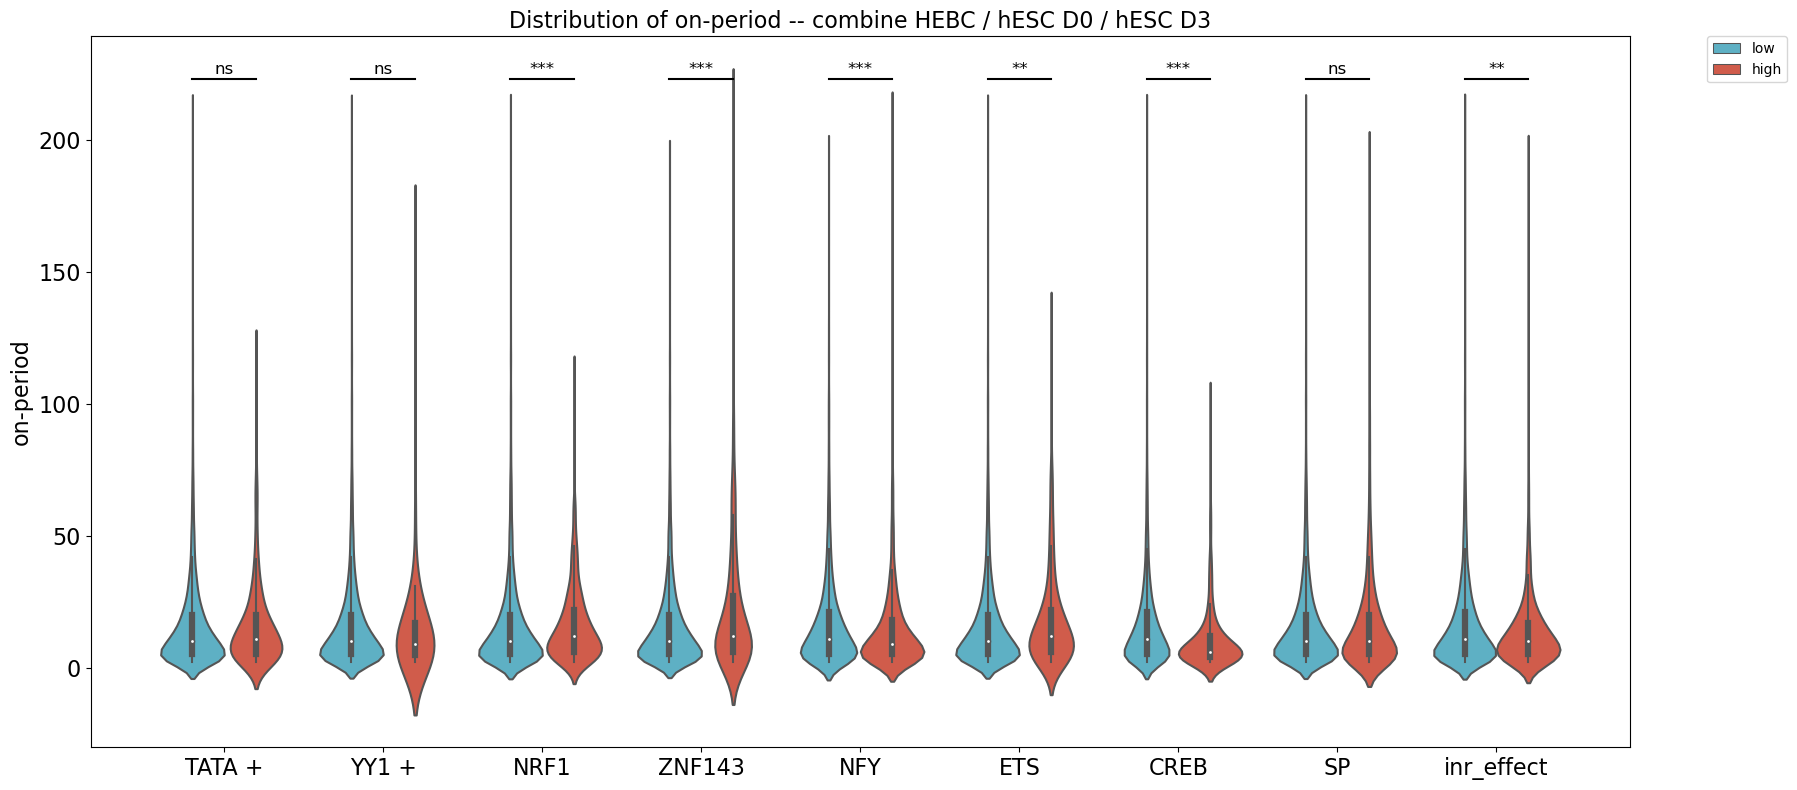

In [13]:
long_data = []

for xcol in xcols:
    data = df_on[~df_on[xcol].isnull()].copy()
    data['group'] = xcol
    data['group_type'] = data.apply(lambda row: f'high' if row[xcol] > 1 else f'low', axis=1)
    long_data.append(data[['on-period', 'group', 'group_type']])

long_data = pd.concat(long_data)

plt.figure(figsize=(18, 8))
ax = sns.violinplot(x='group', y='on-period', hue='group_type', 
                    data=long_data, palette={"high": "#E64B35", "low": "#4DBBD5"})
plt.title('Distribution of on-period -- combine HEBC / hESC D0 / hESC D3', fontsize=16)
plt.ylabel('on-period', fontsize=16)
plt.xlabel('')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Annotate p-values
for xcol in xcols:
    data = df_on[~df_on[xcol].isnull()].copy()
    data[f'{xcol}_group'] = data.apply(lambda row: f'high_{xcol}' if row[xcol] > 1 else f'low_{xcol}', axis=1)
    
    d1 = data[data[f'{xcol}_group'] == f'high_{xcol}']['on-period']
    d2 = data[data[f'{xcol}_group'] == f'low_{xcol}']['on-period']
    
    stat, p = mannwhitneyu(d1, d2)
    
    # Determine significance levels
    if p < 0.001:
        p_value_text = '***'
    elif p < 0.01:
        p_value_text = '**'
    elif p < 0.05:
        p_value_text = '*'
    else:
        p_value_text = 'ns'
    
    # Find the position to annotate the p-value
    group_idx = xcols.index(xcol)
    x_position = group_idx
    y_position = 225

    ax.text(x=x_position, y=y_position, s=p_value_text, ha='center', fontsize=12, color='black')
    
    x1 = group_idx - 0.2
    x2 = group_idx + 0.2
    y = y_position - 2
    h = 0.05  # Line height
    
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')  # Adjust color and line width as needed

plt.savefig("figs/Distribution of on-period.tif", format='tiff')
plt.tight_layout()
plt.show()